In [1]:
from arize.otel import register

tracer_provider = register(
    space_id = "U3BhY2U6MTQ2MjU6SHMrVA==",
    api_key = "1f70d74c0ae7250ebf6",
    project_name = "personAIble", # name this to whatever you would like
)

OpenTelemetry Tracing Details
|  Arize Project: personAIble
|  Span Processor: BatchSpanProcessor
|  Collector Endpoint: otlp.arize.com
|  Transport: gRPC
|  Transport Headers: {'space_id': '****', 'api_key': '****', 'user-agent': '****'}
|  
|  Using a default SpanProcessor. `add_span_processor` will overwrite this default.
|  
|  `register` has set this TracerProvider as the global OpenTelemetry default.
|  To disable this behavior, call `register` with `set_global_tracer_provider=False`.



Transient error StatusCode.UNAVAILABLE encountered while exporting traces to otlp.arize.com, retrying in 1s.


In [2]:
from openinference.instrumentation.openai import OpenAIInstrumentor

OpenAIInstrumentor().instrument(tracer_provider=tracer_provider)

from openinference.instrumentation.langchain import LangChainInstrumentor # pip install openinference-instrumentation-langchain

LangChainInstrumentor().instrument(tracer_provider=tracer_provider)

In [3]:
from langchain import hub
from langchain_community.document_loaders import WebBaseLoader
from langchain_core.documents import Document
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langgraph.graph import START, StateGraph
from typing_extensions import List, TypedDict
from langchain_core.vectorstores import InMemoryVectorStore


from dotenv import load_dotenv
import os
from langchain.document_loaders import JSONLoader
import numpy as np
import matplotlib.pyplot as plt

from concurrent.futures import ThreadPoolExecutor, as_completed # for parallelizing research
import json


USER_AGENT environment variable not set, consider setting it to identify your requests.


In [4]:
from langchain_openai import ChatOpenAI
from langchain_openai import OpenAIEmbeddings

In [5]:
import os
from openai import OpenAI

client = OpenAI(
    # This is the default and can be omitted
    api_key=os.environ.get("OPENAI_API_KEY"),
)

chat_completion = client.chat.completions.create(
    messages=[
        {
            "role": "user",
            "content": "Say this is a test",
        }
    ],
    model="gpt-3.5-turbo",
)

In [6]:
load_dotenv(override=True)  # This will load environment variables from .env file

True

In [7]:
embeddings = OpenAIEmbeddings(model="text-embedding-3-large") ## why?
vector_store = InMemoryVectorStore(embeddings) # why?
llm = ChatOpenAI(model="gpt-4o-mini") # why?

In [8]:
loader1 = JSONLoader(
    file_path="charlesRiverAssets/how.json",
    jq_schema='.', #Get everything (entire JSON)
    text_content=False
)

loader2 = JSONLoader(
    file_path="charlesRiverAssets/whereTo.json",
    jq_schema='.', #Get everything (entire JSON)
    text_content=False
)

loader3 = JSONLoader(
    file_path="charlesRiverAssets/who.json",
    jq_schema='.', #Get everything (entire JSON)
    text_content=False
)

# Combine documents from all loaders
documents = []
for loader in [loader1, loader2, loader3]:
    documents.extend(loader.load())


In [9]:
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=200, 
    chunk_overlap=40,
    separators=["{", "}", ",", "\n"]
    )
all_splits = text_splitter.split_documents(documents)

In [10]:
print(len(all_splits))
for doc in all_splits:
    print("===============")
    print(doc)

41
page_content='{"subPlans": [{"goal":' metadata={'source': 'C:\\Users\\garre\\OneDrive\\Desktop\\Projects\\personAIble\\charlesRiverAssets\\how.json', 'seq_num': 1}
page_content='{"description": "Improve client engagement and streamline post-project support systems for Precision Solutions by April 2024.", "deadline": "2024-04-30"' metadata={'source': 'C:\\Users\\garre\\OneDrive\\Desktop\\Projects\\personAIble\\charlesRiverAssets\\how.json', 'seq_num': 1}
page_content='}, "justification": "To enhance customer satisfaction and strengthen long-term business relationships while reflecting Charles' value of continuous improvement.", "actionItems": [' metadata={'source': 'C:\\Users\\garre\\OneDrive\\Desktop\\Projects\\personAIble\\charlesRiverAssets\\how.json', 'seq_num': 1}
page_content='{"what": "Conduct a comprehensive analysis of current client engagement practices and identify key areas for improvement.", "when": "Every Monday, 9 AM - 11 AM", "duration": "2 hours per session"},' metad

In [11]:
# Index chunks
_ = vector_store.add_documents(documents=all_splits)

In [12]:
whoSchema = """{
    Name: string,
    DOB: string,  // ISO date format
    Gender: string,
    "Core Values": string[],
    "Personality Traits": string[],
    "Hobbies/Interests": string[]
    }"""
whereToSchema = """{
desires: Array<{
    description: string,
    strength: number,  // Scale 1-10
    timeliness: string // Time period or "Ongoing"
}>
}"""
howSchema = """{
subPlan: Array<{
    goal: {
        description: string,
        deadline: string  // ISO date format
    },
    justification: string,
    actionItems: Array<{
        what: string,
        when: string,    // Schedule description
        duration: string  // Time period
    }>
}>
}"""
whoDescription = "personal information about the user."
whereToDescription = "information about the user's most important desires."
howDescription = "information about the user's plan to obtain each of their desires from a high level."
dataSourcesAndDescriptions = [(whoSchema, whoDescription), (whereToSchema, whereToDescription), (howSchema, howDescription)]

In [13]:
user = json.load(open("./charlesRiverAssets/who.json"))["Name"]
promptFXN = lambda state: f"""You are {user}'s assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
            Question: {state['question']}
            Context: {state['context']}
            """

In [36]:
# Define state for application
class State(TypedDict):
    question: str
    context: List[Document]
    answer: str
    desiredInformation: List[str]

def getScore(cosineSimilarity):
    return cosineSimilarity #abs(cosineSimilarity)
# Define application steps

def research(state: State):
    prompt = f"You are a helpful assistant preparing to answer the following question: {state['question']}. Generate a short (2 - 3 item) list of information about the user that would help you to answer their question accurately. Return the list as a newline-separated string."
    response = llm.invoke(prompt)
    return {"desiredInformation": response.content.split("\n")}

def retrieve(state: State, minRelevance = 0.25, numStdDev = 2):
    def getMostRelevant(raw_results):
        scores = np.array([cosine_similarity for _, cosine_similarity in raw_results])
        mean = np.mean(scores)
        std = np.std(scores)
        if True:
            plt.hist(scores)
            plt.show()
        return [raw_results[i][0] for i in np.where(scores >= mean + (std*numStdDev))[0] if raw_results[i][1] >= minRelevance]
    
    desiredInformation = state["desiredInformation"]
    print(len(desiredInformation))
    docs = {}
    raw_results = vector_store.similarity_search_with_score(state["question"], k = len(all_splits))
    relevant = getMostRelevant(raw_results)
    for doc in relevant:
        docs[doc.id] = doc
    with ThreadPoolExecutor() as executor:
        future_to_info = {
            executor.submit(
                vector_store.similarity_search_with_score, info, k=len(all_splits)
            ): info for info in desiredInformation
        }
        for future in as_completed(future_to_info):
            info = future_to_info[future]
            print(f"Processing search results for: {info}")
            raw_results = future.result()
            relevant = getMostRelevant(raw_results)
            # Add relevant docs to shared dict
            for doc in relevant:
                docs[doc.id] = doc
    # for doc in docs.values():
    #     print("DOC: ", doc)
    #     print("DOC TYPE: ", type(doc))
    #     print("DOC DIRECTIONS: ", dir(doc))
    #     print("DOC DICT: ", doc.__dict__)
    #     print("PAGE CONTENT: ", doc.page_content)
    return {"context": [doc.page_content for doc in docs.values()]}

def generate(state: State):
    prompt = promptFXN(state)
    response = llm.invoke(prompt)
    print("STATE PRINT", state)
    return {"answer": response.content}


In [37]:
# Compile application and test
graph_builder = StateGraph(State).add_sequence([research, retrieve, generate])
graph_builder.add_edge(START, "research")
graph_builder.add_edge("research", "retrieve")
graph_builder.add_edge("retrieve", "generate")
graph = graph_builder.compile()

3


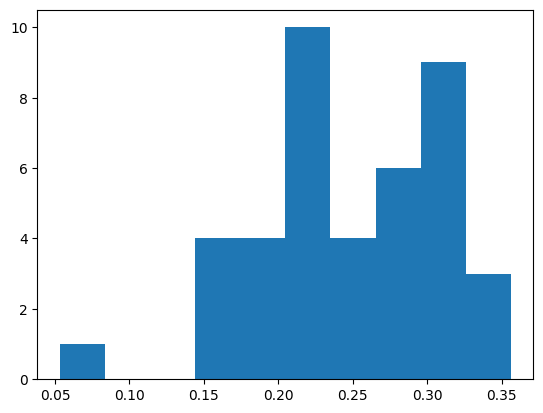

Processing search results for: - What are the long-term goals your team is working toward?


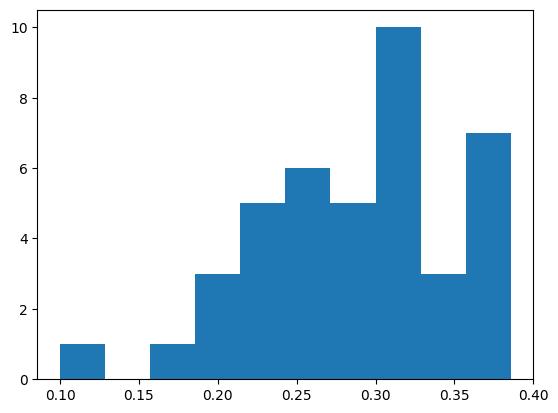

Processing search results for: - What are the core values that guide your team or organization?


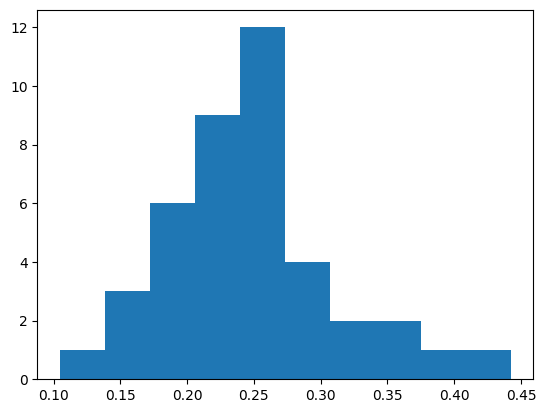

Processing search results for: - What challenges or obstacles is your team currently facing in achieving these goals?


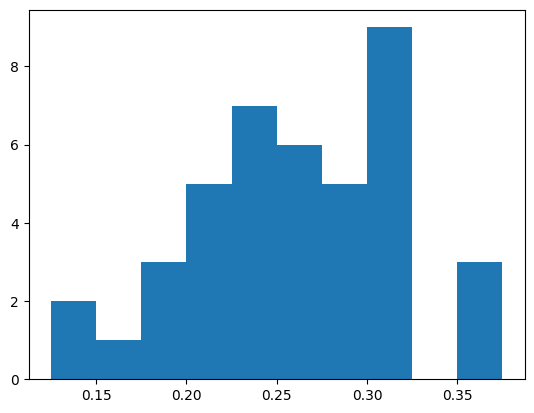

STATE PRINT {'question': 'How can I inspire my team toward achieving our long-term goals while maintaining alignment with our core values?', 'context': [', "Continuous improvement", "Transparency in communication", "Integrity in decision-making", "Resilience in overcoming challenges"], "Personality Traits": ["Goal-oriented", "Systematic", "Resourceful"', '{"Name": "Charles River", "DOB": "1976", "Gender": "Male", "Core Values": ["Precision in execution", "Data-backed decisions", "Open, honest feedback", "Continuous improvement"', '{"what": "Roll out the new onboarding protocol and monitor its impact.", "when": "Bi-weekly on Mondays, 3 PM - 4 PM", "duration": "1 hour per session"}]}, {"goal":'], 'desiredInformation': ['- What are the long-term goals your team is working toward?', '- What are the core values that guide your team or organization?', '- What challenges or obstacles is your team currently facing in achieving these goals?']}
ANSWER:  To inspire your team toward achieving long

In [38]:
question = "How can I inspire my team toward achieving our long-term goals while maintaining alignment with our core values?"
answer = graph.invoke({"question": question})
print("ANSWER: ", answer["answer"])


3


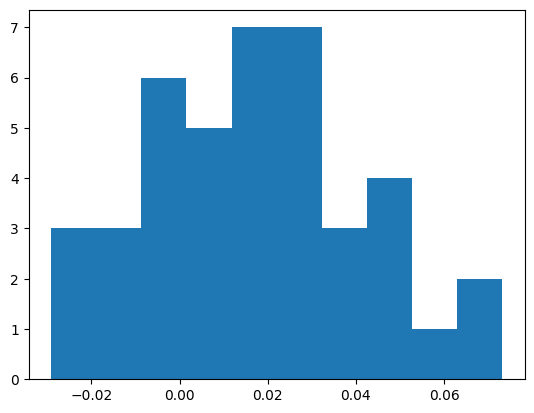

Processing search results for: - The user's interest in understanding the context or origin of the phrase.


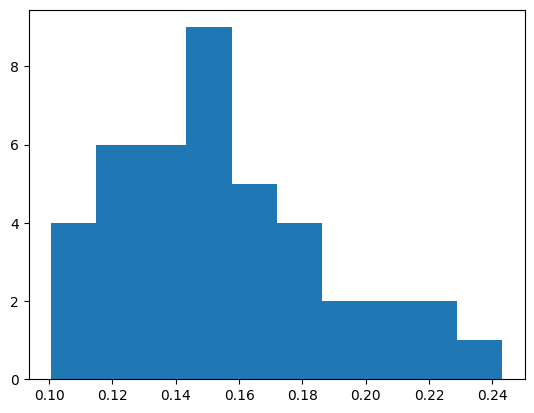

Processing search results for: - The user's preferred level of detail in explanations (e.g., brief overview vs. in-depth analysis).


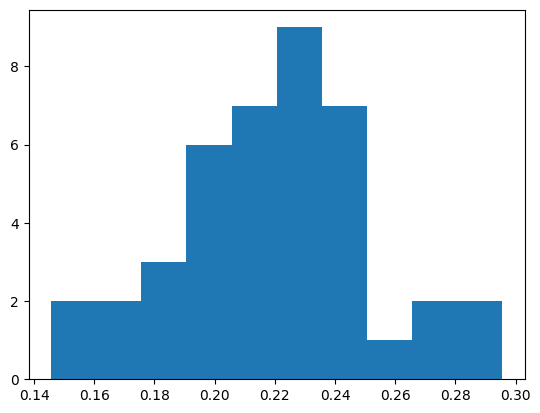

Processing search results for: - The user's familiarity with idiomatic expressions and their meanings.


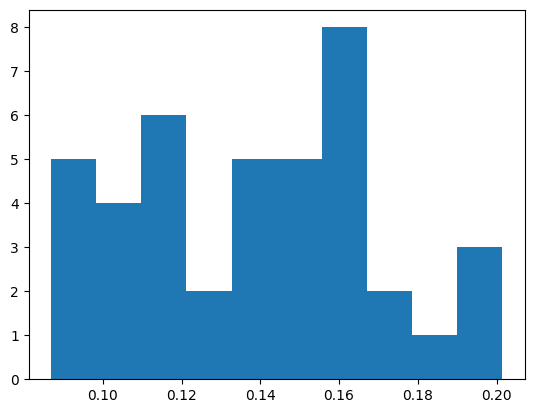

STATE PRINT {'question': "What does the phrase 'curiousity killed the cat' mean?", 'context': ['{"desires": [{"description": "Improve client engagement and streamline post-project support systems for Precision Solutions.", "strength": 9, "timeliness": "6 months"},', '{"what": "Analyze client feedback and identify key retention factors.", "when": "Every Wednesday, 10 AM - 11 AM", "duration": "1 hour per session"},'], 'desiredInformation': ["- The user's familiarity with idiomatic expressions and their meanings.", "- The user's interest in understanding the context or origin of the phrase.", "- The user's preferred level of detail in explanations (e.g., brief overview vs. in-depth analysis)."]}


{'question': "What does the phrase 'curiousity killed the cat' mean?",
 'context': ['{"desires": [{"description": "Improve client engagement and streamline post-project support systems for Precision Solutions.", "strength": 9, "timeliness": "6 months"},',
  '{"what": "Analyze client feedback and identify key retention factors.", "when": "Every Wednesday, 10 AM - 11 AM", "duration": "1 hour per session"},'],
 'answer': 'The phrase "curiosity killed the cat" means that inquisitive behavior can lead to trouble or danger. It serves as a warning about the potential risks of seeking out knowledge or information. Ultimately, it suggests that sometimes, it’s better to be cautious than to pry into matters that may not concern us.',
 'desiredInformation': ["- The user's familiarity with idiomatic expressions and their meanings.",
  "- The user's interest in understanding the context or origin of the phrase.",
  "- The user's preferred level of detail in explanations (e.g., brief overview vs. in-

In [39]:
graph.invoke({"question": "What does the phrase 'curiousity killed the cat' mean?"})

3


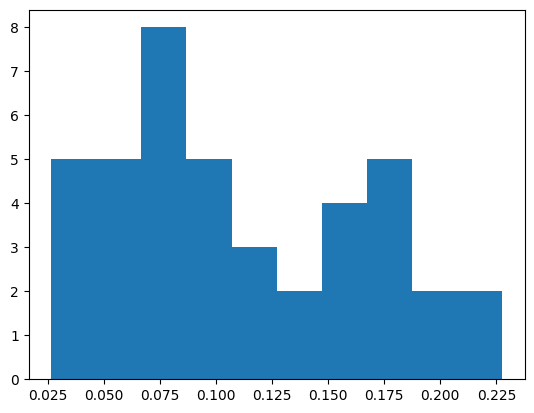

Processing search results for: - Availability of resources or equipment (e.g., access to a car, sports gear, art supplies).


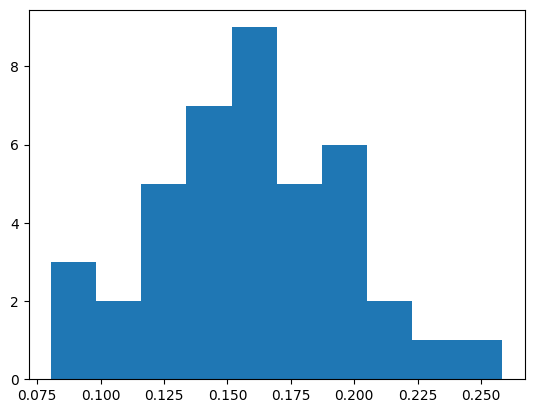

Processing search results for: - Interests and hobbies of the family (e.g., outdoor activities, arts and crafts, sports).


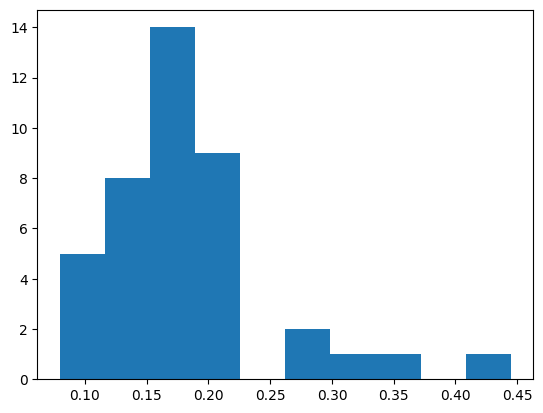

Processing search results for: - The age range of family members participating in the activities.


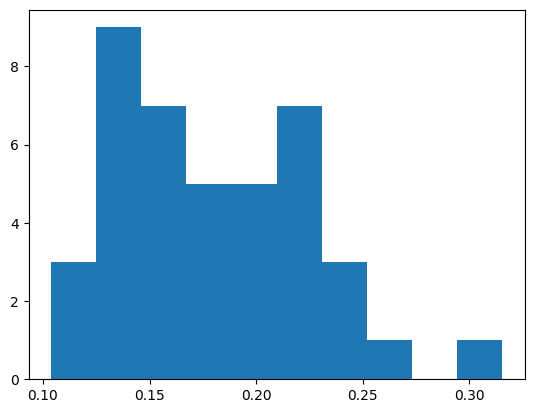

STATE PRINT {'question': 'What are some fun activities I can do with my family over the weekend?', 'context': [Document(id='48dfdadb-10c3-465a-8331-a4214530d361', metadata={'source': 'C:\\Users\\garre\\OneDrive\\Desktop\\Projects\\personAIble\\charlesRiverAssets\\who.json', 'seq_num': 1}, page_content=', "Systematic", "Resourceful", "Strategic foresight", "Analytical thinking", "Decisive"], "Hobbies/Interests": ["Backpacking and hiking", "Crafting custom modern furniture"'), Document(id='5b860159-90c7-41f2-8378-3bcfbc950ace', metadata={'source': 'C:\\Users\\garre\\OneDrive\\Desktop\\Projects\\personAIble\\charlesRiverAssets\\whereTo.json', 'seq_num': 1}, page_content='{"description": "Strengthen personal relationships with family by ensuring they feel prioritized.", "strength": 9, "timeliness": "ongoing"}]}'), Document(id='812a2066-9591-417a-bb65-faa0683f1ba8', metadata={'source': 'C:\\Users\\garre\\OneDrive\\Desktop\\Projects\\personAIble\\charlesRiverAssets\\who.json', 'seq_num': 1},

{'question': 'What are some fun activities I can do with my family over the weekend?',
 'context': [Document(id='48dfdadb-10c3-465a-8331-a4214530d361', metadata={'source': 'C:\\Users\\garre\\OneDrive\\Desktop\\Projects\\personAIble\\charlesRiverAssets\\who.json', 'seq_num': 1}, page_content=', "Systematic", "Resourceful", "Strategic foresight", "Analytical thinking", "Decisive"], "Hobbies/Interests": ["Backpacking and hiking", "Crafting custom modern furniture"'),
  Document(id='5b860159-90c7-41f2-8378-3bcfbc950ace', metadata={'source': 'C:\\Users\\garre\\OneDrive\\Desktop\\Projects\\personAIble\\charlesRiverAssets\\whereTo.json', 'seq_num': 1}, page_content='{"description": "Strengthen personal relationships with family by ensuring they feel prioritized.", "strength": 9, "timeliness": "ongoing"}]}'),
  Document(id='812a2066-9591-417a-bb65-faa0683f1ba8', metadata={'source': 'C:\\Users\\garre\\OneDrive\\Desktop\\Projects\\personAIble\\charlesRiverAssets\\who.json', 'seq_num': 1}, page_c

In [71]:
graph.invoke({"question": "What are some fun activities I can do with my family over the weekend?"})

3


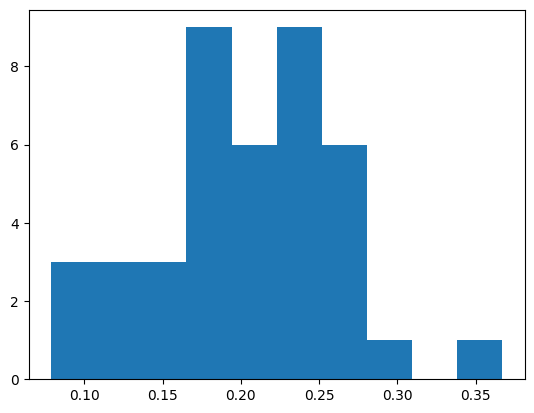

Processing search results for: - What specific goals do you have for these professional relationships or collaborations?


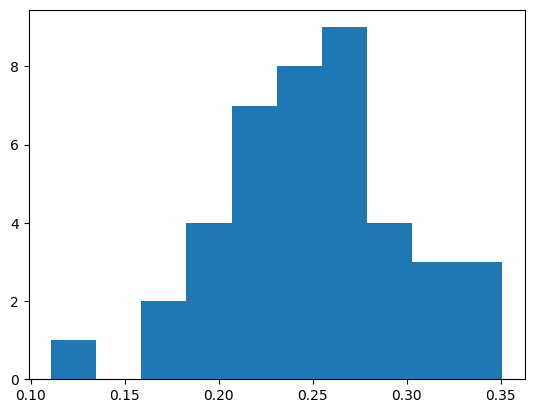

Processing search results for: - What industry or field do you work in, and what is your role?


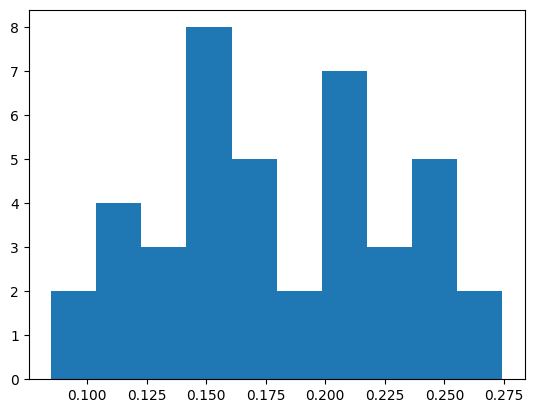

Processing search results for: - Are you looking to build relationships with colleagues, clients, or industry peers?


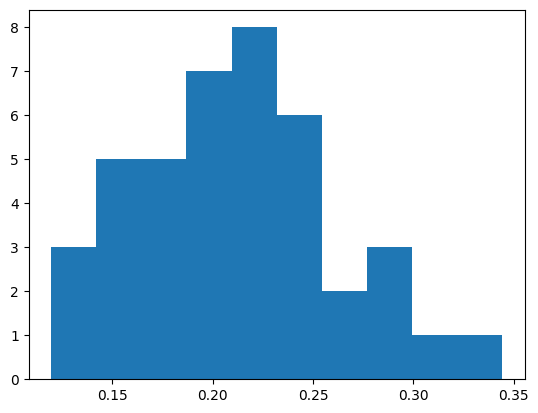

STATE PRINT {'question': 'What strategies can I use to build stronger, more meaningful professional relationships and collaborations?', 'context': [Document(id='5b860159-90c7-41f2-8378-3bcfbc950ace', metadata={'source': 'C:\\Users\\garre\\OneDrive\\Desktop\\Projects\\personAIble\\charlesRiverAssets\\whereTo.json', 'seq_num': 1}, page_content='{"description": "Strengthen personal relationships with family by ensuring they feel prioritized.", "strength": 9, "timeliness": "ongoing"}]}'), Document(id='f6119d83-53fa-4e2e-b091-1645a327a609', metadata={'source': 'C:\\Users\\garre\\OneDrive\\Desktop\\Projects\\personAIble\\charlesRiverAssets\\how.json', 'seq_num': 1}, page_content='{"what": "Participate in relevant projects to apply Lean Six Sigma principles.", "when": "Monthly project engagement", "duration": "Variable"}]}, {"goal":'), Document(id='f5fcaf6c-3d54-4f4e-9706-60b22c114717', metadata={'source': 'C:\\Users\\garre\\OneDrive\\Desktop\\Projects\\personAIble\\charlesRiverAssets\\how.js

{'question': 'What strategies can I use to build stronger, more meaningful professional relationships and collaborations?',
 'context': [Document(id='5b860159-90c7-41f2-8378-3bcfbc950ace', metadata={'source': 'C:\\Users\\garre\\OneDrive\\Desktop\\Projects\\personAIble\\charlesRiverAssets\\whereTo.json', 'seq_num': 1}, page_content='{"description": "Strengthen personal relationships with family by ensuring they feel prioritized.", "strength": 9, "timeliness": "ongoing"}]}'),
  Document(id='f6119d83-53fa-4e2e-b091-1645a327a609', metadata={'source': 'C:\\Users\\garre\\OneDrive\\Desktop\\Projects\\personAIble\\charlesRiverAssets\\how.json', 'seq_num': 1}, page_content='{"what": "Participate in relevant projects to apply Lean Six Sigma principles.", "when": "Monthly project engagement", "duration": "Variable"}]}, {"goal":'),
  Document(id='f5fcaf6c-3d54-4f4e-9706-60b22c114717', metadata={'source': 'C:\\Users\\garre\\OneDrive\\Desktop\\Projects\\personAIble\\charlesRiverAssets\\how.json', 's

In [74]:
graph.invoke({"question": "What strategies can I use to build stronger, more meaningful professional relationships and collaborations?"})

3


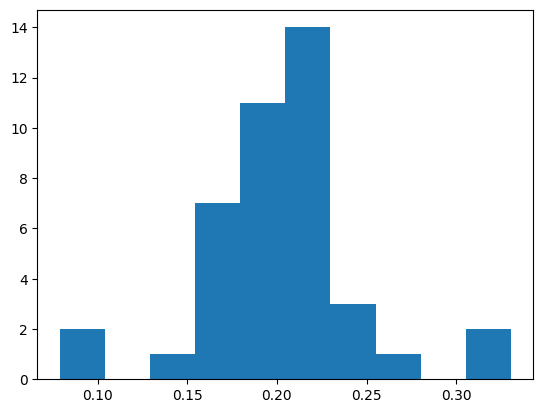

Processing search results for: 1. What industry or field do you work in, and what specific role do you hold?


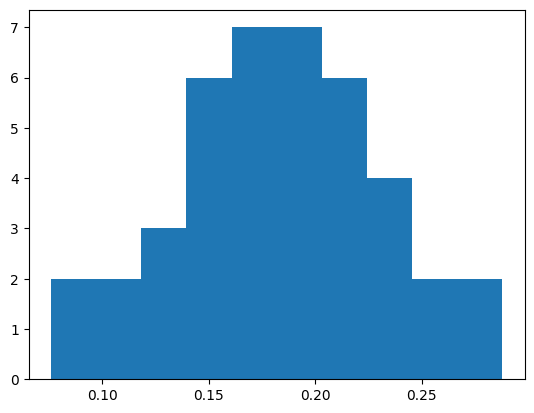

Processing search results for: 2. What are your personal values and goals regarding the impact you wish to achieve?


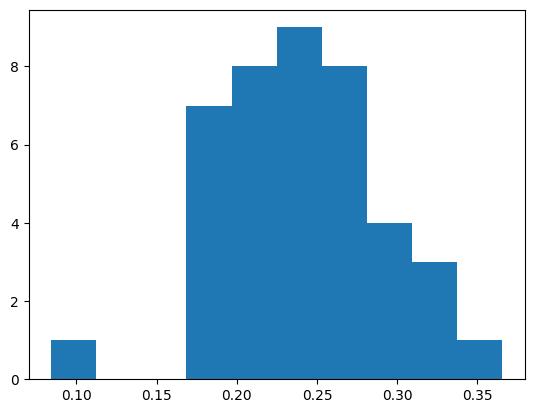

Processing search results for: 3. Are there any particular communities or causes you are passionate about supporting?


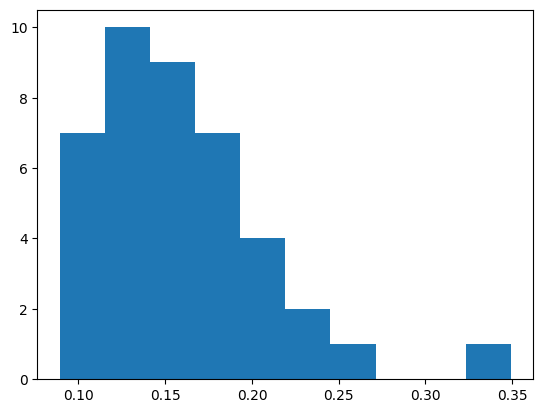

STATE PRINT {'question': 'How can I ensure that my work leaves a lasting positive impact on my industry, community, or the world?', 'context': [Document(id='47a65386-659a-4ad5-a3ba-d6c4cdba8aac', metadata={'source': 'C:\\Users\\garre\\OneDrive\\Desktop\\Projects\\personAIble\\charlesRiverAssets\\how.json', 'seq_num': 1}, page_content='}, "justification": "To share knowledge and mentor emerging leaders, aligning with Charles\' interest in mentoring and community impact.", "actionItems": ['), Document(id='9df85c17-8995-4d89-9d56-2152b3de0be9', metadata={'source': 'C:\\Users\\garre\\OneDrive\\Desktop\\Projects\\personAIble\\charlesRiverAssets\\whereTo.json', 'seq_num': 1}, page_content='{"description": "Create a legacy of professional excellence and community impact.", "strength": 10, "timeliness": "10 years"},'), Document(id='f5fcaf6c-3d54-4f4e-9706-60b22c114717', metadata={'source': 'C:\\Users\\garre\\OneDrive\\Desktop\\Projects\\personAIble\\charlesRiverAssets\\how.json', 'seq_num': 1}

{'question': 'How can I ensure that my work leaves a lasting positive impact on my industry, community, or the world?',
 'context': [Document(id='47a65386-659a-4ad5-a3ba-d6c4cdba8aac', metadata={'source': 'C:\\Users\\garre\\OneDrive\\Desktop\\Projects\\personAIble\\charlesRiverAssets\\how.json', 'seq_num': 1}, page_content='}, "justification": "To share knowledge and mentor emerging leaders, aligning with Charles\' interest in mentoring and community impact.", "actionItems": ['),
  Document(id='9df85c17-8995-4d89-9d56-2152b3de0be9', metadata={'source': 'C:\\Users\\garre\\OneDrive\\Desktop\\Projects\\personAIble\\charlesRiverAssets\\whereTo.json', 'seq_num': 1}, page_content='{"description": "Create a legacy of professional excellence and community impact.", "strength": 10, "timeliness": "10 years"},'),
  Document(id='f5fcaf6c-3d54-4f4e-9706-60b22c114717', metadata={'source': 'C:\\Users\\garre\\OneDrive\\Desktop\\Projects\\personAIble\\charlesRiverAssets\\how.json', 'seq_num': 1}, page_

In [75]:
graph.invoke({"question": "How can I ensure that my work leaves a lasting positive impact on my industry, community, or the world?"})

3


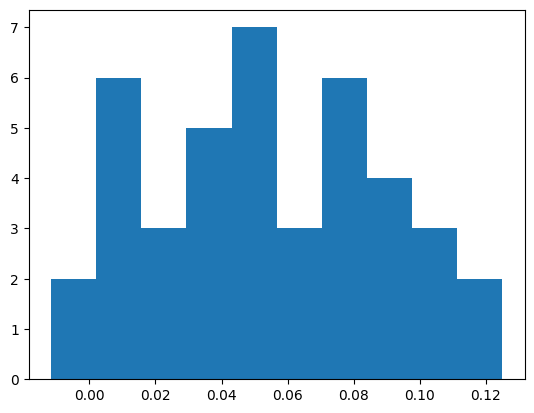

Processing search results for: - What are your children's ages and any dietary restrictions or allergies they may have?


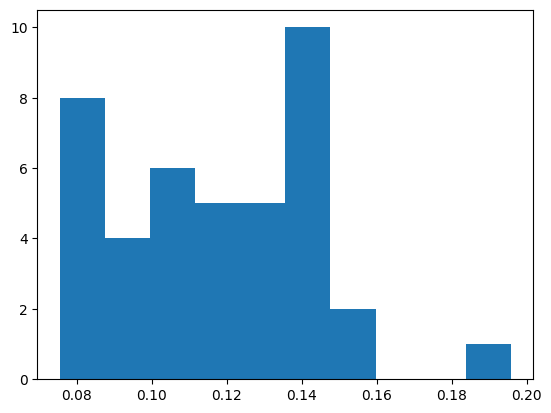

Processing search results for: - Do your kids have any particular food preferences or dislikes?


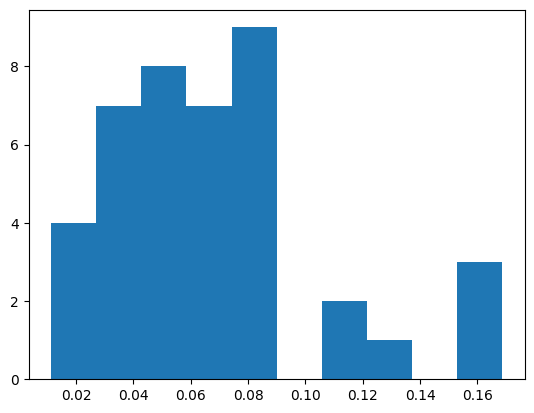

Processing search results for: - How much time do you have to prepare the lunch?


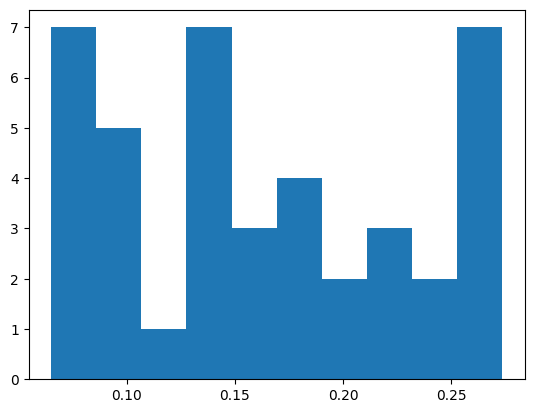

STATE PRINT {'question': 'What should I feed my kids for lunch today?', 'context': [], 'desiredInformation': ["- What are your children's ages and any dietary restrictions or allergies they may have?", '- Do your kids have any particular food preferences or dislikes?', '- How much time do you have to prepare the lunch?']}


{'question': 'What should I feed my kids for lunch today?',
 'context': [],
 'answer': "I don't know.",
 'desiredInformation': ["- What are your children's ages and any dietary restrictions or allergies they may have?",
  '- Do your kids have any particular food preferences or dislikes?',
  '- How much time do you have to prepare the lunch?']}

In [76]:
graph.invoke({"question": "What should I feed my kids for lunch today?"})

3


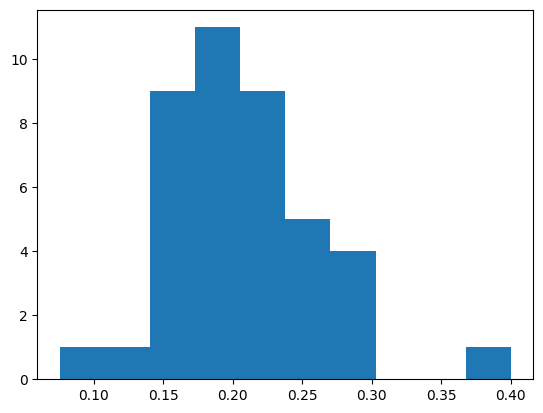

Processing search results for: - Current professional goals and aspirations (e.g., job role, desired achievements)


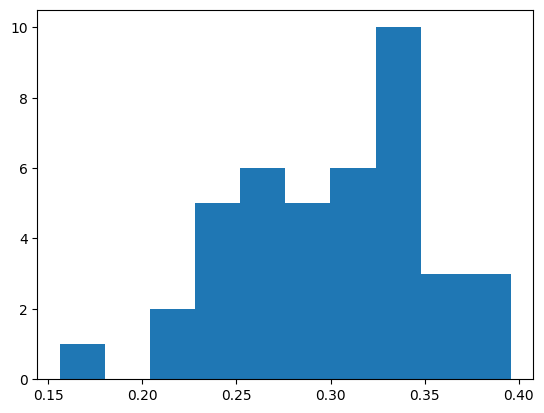

Processing search results for: - Current self-care practices and well-being routines (e.g., hobbies, exercise, relaxation techniques)


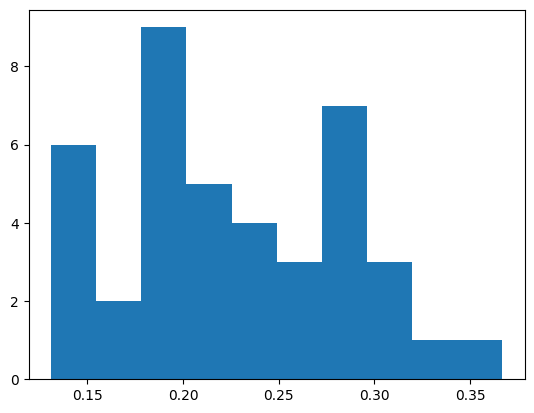

Processing search results for: - Existing personal relationships and support system (e.g., family, friends, significant others)


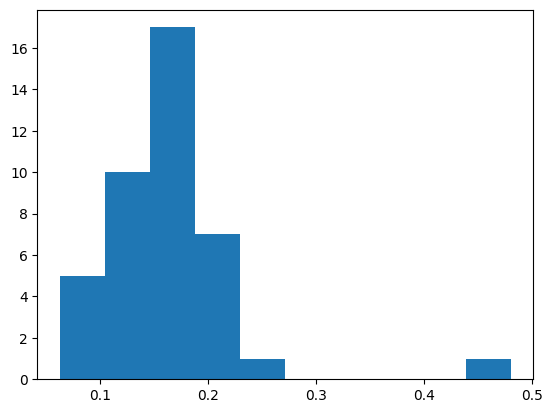

STATE PRINT {'question': 'How do I maintain a healthy balance between achieving my professional goals and nurturing my personal relationships and well-being?', 'context': [Document(id='5b860159-90c7-41f2-8378-3bcfbc950ace', metadata={'source': 'C:\\Users\\garre\\OneDrive\\Desktop\\Projects\\personAIble\\charlesRiverAssets\\whereTo.json', 'seq_num': 1}, page_content='{"description": "Strengthen personal relationships with family by ensuring they feel prioritized.", "strength": 9, "timeliness": "ongoing"}]}')], 'desiredInformation': ['- Current professional goals and aspirations (e.g., job role, desired achievements)', '- Existing personal relationships and support system (e.g., family, friends, significant others)', '- Current self-care practices and well-being routines (e.g., hobbies, exercise, relaxation techniques)']}


{'question': 'How do I maintain a healthy balance between achieving my professional goals and nurturing my personal relationships and well-being?',
 'context': [Document(id='5b860159-90c7-41f2-8378-3bcfbc950ace', metadata={'source': 'C:\\Users\\garre\\OneDrive\\Desktop\\Projects\\personAIble\\charlesRiverAssets\\whereTo.json', 'seq_num': 1}, page_content='{"description": "Strengthen personal relationships with family by ensuring they feel prioritized.", "strength": 9, "timeliness": "ongoing"}]}')],
 'answer': 'To maintain a healthy balance, prioritize your personal relationships by ensuring your family feels valued and prioritized. Regularly set aside time for both professional and personal commitments. Additionally, be mindful of your well-being by incorporating self-care practices into your routine.',
 'desiredInformation': ['- Current professional goals and aspirations (e.g., job role, desired achievements)',
  '- Existing personal relationships and support system (e.g., family, fri

In [77]:
graph.invoke({"question": "How do I maintain a healthy balance between achieving my professional goals and nurturing my personal relationships and well-being?"})
